In [1]:
%pip install requests colorama bs4 tqdm requests_ratelimiter folium geopy matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import colorama
from bs4 import BeautifulSoup
from tqdm import tqdm
from requests_ratelimiter import LimiterSession
from time import time
from collections import Counter
import csv
from itertools import zip_longest
import folium
from folium.plugins import MarkerCluster
import ast
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt

We scrape the *LRB*’s webpage for all letters. The first issue has no locations, and the first volume has only six numbers. (Commented to avoid scraping unnecessarily.)

In [3]:
# session = LimiterSession(per_second=5)
# with open("lrb_letters.csv", "w") as file:
#     writer = csv.writer(file)
#     for number in range(2,6):
#         soup = BeautifulSoup(session.get(
#             f"https://www.lrb.co.uk/the-paper/v01/n{number:02d}/letters").text)
#         writer.writerow([1,number]+
#                         [signed.text for signed in soup.findAll(
#                             "p", attrs={"class":"letter-from"})])
#     for volume in tqdm(range(2,47)):
#         for number in range(1,25):
#             soup = BeautifulSoup(session.get(
#                 f"https://www.lrb.co.uk/the-paper/v{volume:02d}/n{number:02d}/letters").text)
#             writer.writerow([volume,number]+
#                             [signed.text for signed in soup.findAll(
#                             "p", attrs={"class":"letter-from"})])

Subscriptions usually take the form of a name followed by an address or affiliation in a separate line. We parse each issue.

In [4]:
raw = []
with open('lrb_letters.csv') as file:
    raw += list(csv.reader(file))

def parse_subscription(subscription):
    return [line.strip() for line in subscription.split("\n") if line.strip()]
def parse_issue(issue):
    return [parse_subscription(subscription) for subscription in issue[2:]]

parsed = [parse_issue(issue) for issue in raw]
flattened = [x for y in parsed for x in y if x]
names = [subscription[0] for subscription in flattened]

Who writes the most letters?

In [5]:
Counter(names).most_common(25)

[('Editor, ‘London Review’', 110),
 ('Editors, ‘London Review’', 70),
 ('Keith Flett', 68),
 ('Nicolas Walter', 39),
 ('R.W. Johnson', 38),
 ('David Elstein', 33),
 ('Stephen Sedley', 32),
 ('David Craig', 30),
 ('Edward Luttwak', 25),
 ('Jeremy Bernstein', 23),
 ('James Wood', 21),
 ('John Bayley', 20),
 ('Adrian Bowyer', 20),
 ('Chris Purnell', 19),
 ('Frank Kermode', 18),
 ('Phil Edwards', 18),
 ('Anne Summers', 17),
 ('Roy MacGregor-Hastie', 16),
 ('Christopher Hitchens', 16),
 ('Marina Warner', 16),
 ('Ian Birchall', 15),
 ('Bernard Richards', 14),
 ('Christopher Price', 14),
 ('Craig Raine', 14),
 ('Fiona Pitt-Kethley', 14)]

Whence come they? This is not wholly straightforward, because the same affiliation may be printed differently (‘Trinity College, Cambridge’ is ‘Trinity College, University of Cambridge’, for example), sometimes the country is included or omitted, &c. A first try follows.

In [6]:
locations = [subscription[1] for subscription in flattened if len(subscription) > 1]
Counter(locations).most_common(25)

[('New York', 240),
 ('Oxford', 233),
 ('Cambridge', 160),
 ('London NW3', 120),
 ('London N1', 105),
 ('Bristol', 95),
 ('London NW5', 92),
 ('London WC1', 91),
 ('Edinburgh', 81),
 ('London NW1', 75),
 ('London N17', 69),
 ('Paris', 58),
 ('London NW6', 57),
 ('Washington DC', 54),
 ('London W11', 53),
 ('Dublin', 51),
 ('Toronto', 51),
 ('London SW1', 50),
 ('London SW15', 47),
 ('Manchester', 47),
 ('Glasgow', 46),
 ('Los Angeles', 46),
 ('Brighton', 42),
 ('Sheffield', 42),
 ('University College London', 42)]

From which postcodes come the Londoners? (Again, this is an approximation: consider e.g. ‘Faber, London WC1’.)

In [7]:
londoners_with_postcodes = [location for location in locations if location.startswith("London")]
Counter(londoners_with_postcodes).most_common(25)

[('London NW3', 120),
 ('London N1', 105),
 ('London NW5', 92),
 ('London WC1', 91),
 ('London NW1', 75),
 ('London N17', 69),
 ('London NW6', 57),
 ('London W11', 53),
 ('London SW1', 50),
 ('London SW15', 47),
 ('London SE3', 41),
 ('London N5', 40),
 ('London E8', 40),
 ('London N16', 38),
 ('London N19', 36),
 ('London W2', 35),
 ('London SW11', 33),
 ('London W1', 30),
 ('London W12', 30),
 ('London SW2', 26),
 ('London SE1', 26),
 ('London N7', 26),
 ('London SW4', 25),
 ('London NW11', 24),
 ('London N6', 24)]

We can try to compare cities again with a slightly broader criterion of inclusion:

In [8]:
for city in ["London", "New York", "Oxford", "Cambridge", "Bristol", "Edinburgh", "Paris", "Washington DC", "Dublin", "Toronto"]:
    all = [location for location in locations if city in location]
    print(f"{city}: {len(all)}")

London: 2465
New York: 421
Oxford: 572
Cambridge: 407
Bristol: 118
Edinburgh: 107
Paris: 74
Washington DC: 58
Dublin: 70
Toronto: 68


Which Oxonocantabrigian college sends the most letters?

In [9]:
oxonians = [location for location in locations if ", Oxford" in location or ("University" in location and "Oxford" in location)]
tabs = [location for location in locations if ", Cambridge" in location or ("University" in location and "Cambridge" in location)]

In [10]:
Counter([row.split(",")[0] for row in oxonians]).most_common()[:15]

[('All Souls College', 18),
 ('St Antony’s College', 17),
 ('Magdalen College', 16),
 ('Brasenose College', 14),
 ('New College', 10),
 ('St John’s College', 10),
 ('St Hugh’s College', 9),
 ('Somerville College', 9),
 ('Balliol College', 9),
 ('Jesus College', 9),
 ('Worcester College', 7),
 ('St Catherine’s College', 7),
 ('Wolfson College', 7),
 ('Trinity College', 7),
 ('Christ Church', 6)]

In [11]:
Counter([row.split(",")[0] for row in tabs]).most_common()[:15]

[('Trinity College', 26),
 ('King’s College', 20),
 ('St John’s College', 15),
 ('Gonville and Caius College', 13),
 ('Girton College', 7),
 ('Clare College', 6),
 ('University of Cambridge', 6),
 ('Robinson College', 5),
 ('Great Chishill', 5),
 ('Jesus College', 4),
 ('Christ’s College', 4),
 ('Corpus Christi College', 4),
 ('Pembroke College', 4),
 ('Churchill College', 4),
 ('Peterhouse', 4)]

How many letters are in the corpus in total?

In [12]:
len(flattened)

10429

Not many letters are sent from Asia.

In [13]:
for city in ["Delhi", "Calcutta", "Kolkota", "Mumbai"]:
    all = [location for location in locations if city in location]
    print(f"{city}: {len(all)}")

Delhi: 5
Calcutta: 4
Kolkota: 0
Mumbai: 0


In [14]:
for city in ["Beijing", "Shanghai", "Hong Kong", "Singapore", "Tokyo", "Seoul", "Kuala Lumpur"]:
    all = [location for location in locations if city in location]
    print(f"{city}: {len(all)}")

Beijing: 0
Shanghai: 1
Hong Kong: 7
Singapore: 2
Tokyo: 14
Seoul: 0
Kuala Lumpur: 2


Which areas are most often explicitly included in affilations?

In [15]:
for subject in ["Philosophy", "History", "Mathematic", "Comput", "Cogniti", "English", "French", "Literature", "Linguistics", "Psychology", "Psychiatry", "Psychoanaly", "Science"]:
    all = [location for location in locations if subject in location]
    print(f"{subject}: {len(all)}")

Philosophy: 12
History: 30
Mathematic: 1
Comput: 1
Cogniti: 1
English: 50
French: 3
Literature: 11
Linguistics: 2
Psychology: 9
Psychiatry: 6
Psychoanaly: 1
Science: 22


We now put letters on a map. First, we have to work from partial affiliations/addresses to coördinates. There are 3552 to attempt.

In [16]:
location_set = set(locations)
len(location_set)

3552

Put `app` as one’s preferred `geopy` geocoder service. I used `ArcGIS` (imported above). Commented to avoid repeated requests, since I’m lazy.

In [17]:
# with open("locations.csv", "w") as file:
#     writer = csv.writer(file)
#     for place in tqdm(location_set):
#         res = app.geocode(place)
#         if res:
#             writer.writerow([place, res.raw])

How many did we get? (Note that we require the confidence score to be greater than 95.)

In [18]:
geocodes = {}
with open("locations.csv") as file:
    for row in csv.reader(file):
        parsed_json = ast.literal_eval(row[1])
        if parsed_json["score"] > 90:
            geocodes[row[0]] = parsed_json
len(geocodes)

3015

Observing the result, there were some clear errors: Ipswich is in Suffolk, not next to Brisbane; the House of Lords is not in Mumbai; and Faber is not in Singapore. These corrections are not exhaustive. (The corrections must map to an address in the dataset with known coördinates to work.)

We process each letter by volume and number, to generate a backlink to the relevant letters page. For each location, we add the details of each letter. We also keep track of how many letters were sent from that location. (This is after the corrections.)

In [19]:
by_location = {}
corrections = {
    "House of Lords": "House of Lords SW1",
    "Faber": "Faber, London WC1",
    "Ipswich": "Ipswich, Suffolk",
    "Royal Holloway College": "Royal Holloway, University of London",
    "Inquest": None
}
for issue in raw:
    url = f"https://www.lrb.co.uk/the-paper/v{int(issue[0]):02d}/n{int(issue[1]):02d}/letters"
    for i, subscription in enumerate(parse_issue(issue)):
        if len(subscription) == 2:
            address = subscription[1]
            if subscription[1] in corrections:
                address = corrections[address]
            res = geocodes.get(address)
            if res:
                location_dict = res.get("location")
                location = (location_dict["y"], location_dict["x"])
                if location:
                    to_add = f"<li>{subscription[0].strip()} · <a href=\"{url}\">volume {issue[0]}, number {issue[1]}</a>.</li>"
                    if location not in by_location:
                        by_location[location] = {
                            "location": subscription[1],
                            "links": [to_add],
                            "num_letters": 1
                        }
                    else:
                        by_location[location]["links"].append(to_add)
                        by_location[location]["num_letters"] += 1

With a rather dirty hack we then count up the number of letters in each location in the following marker clusters (instead of the number of markers, which would not reflect the actual number of letters).

In [20]:
m = folium.Map()
icon_create_function = """\
function(cluster) {
    return L.divIcon({
    html: cluster.getAllChildMarkers().map(m => m.options.options.num_letters).reduce((pv, cv) => pv + cv, 0),
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""
cluster = MarkerCluster(icon_create_function=icon_create_function).add_to(m)
for location, entry in by_location.items():
    folium.Marker(
        location=location,
        popup=folium.Popup(f"<p><b>{entry['location']}</b></p><ol>{''.join(entry['links'])}</ol>",max_width=1000, max_height=100),
        options={"num_letters": entry["num_letters"]}
    ).add_to(cluster)
m.save("lrb-letters-map.html")
m

How has the proportion of letters from London, Oxford, and Cambridge varied over time?

In [21]:
volumes = {}
cities = ["London", "Oxford", "Cambridge", "New York"]
for issue in raw:
    volume = int(issue[0])
    subscriptions = parse_issue(issue)
    if volume not in volumes:
        volumes[volume] = {"total": 0, **{city: 0 for city in cities}}
    else:
        volumes[volume]["total"] += len(subscriptions)
    for subscription in subscriptions:
        for city in cities:
            if len(subscription) > 1 and city in subscription[1]:
                volumes[volume][city] += 1

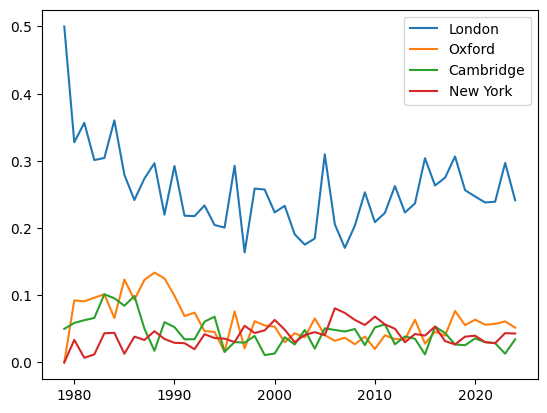

In [22]:
years = [y+1979 for y in range(46)]
for city in cities:
    plt.plot(years, [volumes[vol][city]/volumes[vol]["total"] for vol in range(1,47)], label=city)
plt.legend()
plt.show()